In [ ]:
!pip install arch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from arch import arch_model
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
## Plot diagnostics for G/ARCH models
def assess_fit_plots( e, name ):
    #Plot standardised residuals.
    plt.plot( e )
    plt.title( '{0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of standardised residuals.
    sm.graphics.tsa.plot_acf( e, lags=20 )
    plt.title( 'ACF of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the histogram of standardised residuals.
    plt.hist( e, bins = 25 )
    plt.title( 'Histogram of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## QQ plot of standardised residuals against the normal distribution.
    sm.qqplot( e, line = 'r')
    plt.title( 'QQ Plot of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of squared standardised residuals.
    sm.graphics.tsa.plot_acf( e*e, lags=20 )
    plt.title( 'ACF of {0} Squared Standardised Residuals'.format( name ) )
    plt.show()

In [ ]:
## Statistical diagnostics for G/ARCH models as introduced in Tutorial 7.
def assess_fit_stats( e, df ):
    ## Ljung-Box tests on standardised residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print( "Ljung-Box Q-statistic on standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        results = acorr_ljungbox( e, lags = [p], model_df = df, return_df = False )
        print(results)
    print()

    ## Ljung-Box tests on squared standardised residuals
    print( "Ljung-Box Q-statistic on squared standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        results_2 = acorr_ljungbox( e*e, lags = [p], model_df = df, return_df = False )
        print(results_2)
    print()

    ## ARCH test on mean-corrected returns. Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH).
    ## The null hypothesis is no ARCH errors.
    from statsmodels.stats.diagnostic import het_arch
    print( "Engle ARCH statistic:")
    for p in [ 5, 10 ]:
        Teststat, pValue, _, _ = het_arch( resid=e, nlags=p )
        print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )
    print()

    ## Jarque-Bera tests
    from statsmodels.stats.stattools import jarque_bera
    print( 'Skewness: {0:f}'.format( stats.skew( e ) ) )
    print( 'Kurtosis: {0:f}'.format( stats.kurtosis( e ) + 3 ) )
    JB_test_stat, JB_pvalue, _, _ = jarque_bera( e )
    print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
    print()
###if  P value = 0; standardised residuals are significantly non-gaussian

In [ ]:
#Summary statistics
import scipy.stats as st
def summarise( y ):
    print( 'Mean:     ', np.mean( y ) )
    print( 'Median:   ', np.median( y ) )
    print( 'Stdev:    ', np.std( y ) )
    print( 'Skewness: ', st.skew( y ) )
    print( 'Kurtosis: ', st.kurtosis( y, fisher=False ) ) ## Pearson's definition ( normal == 3.0 )
    print( 'Min:      ', np.min( y ) )
    print( 'Max:      ', np.max( y ) )


In [ ]:
STKdata = pd.read_csv('GNE.AX.csv', parse_dates=['Date'], dayfirst = True)
print( STKdata.tail() )

STKdates = STKdata['Date']
STKp = STKdata['Adj Close']

## Compute log-returns.
STKr = ( 100 * ( np.log( STKp ) - np.log( STKp.shift() ) ) )[1:]
assert( np.isnan( STKr ).sum() == 0 )

            Date  Open  High   Low  Close  Adj Close  Volume
2528  2024-05-27  2.01  2.02  1.98  2.010      2.010   47444
2529  2024-05-28  2.00  2.00  1.95  1.975      1.975   56291
2530  2024-05-29  1.96  1.99  1.95  1.990      1.990  359012
2531  2024-05-30  2.00  2.00  1.93  1.930      1.930  102816
2532  2024-05-31  1.94  1.97  1.94  1.940      1.940   18069


In [ ]:
last_date = STKdates.iloc[-1]
future_dates = pd.date_range(start=last_date, periods=200, freq='D')
future_dates

DatetimeIndex(['2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03',
               '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07',
               '2024-06-08', '2024-06-09',
               ...
               '2024-12-07', '2024-12-08', '2024-12-09', '2024-12-10',
               '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-14',
               '2024-12-15', '2024-12-16'],
              dtype='datetime64[ns]', length=200, freq='D')

In [ ]:
## Put dates, prices and returns all on the same basis.
STKdates = STKdates[2:]
STKp = STKp[2:]

n = len(STKr) #Total sample size
n

2532

In [ ]:
STKdates

2       2014-06-04
3       2014-06-05
4       2014-06-06
5       2014-06-10
6       2014-06-11
           ...    
2528    2024-05-27
2529    2024-05-28
2530    2024-05-29
2531    2024-05-30
2532    2024-05-31
Name: Date, Length: 2531, dtype: object

In [ ]:
STKp

2       0.800353
3       0.800353
4       0.795443
5       0.795443
6       0.800353
          ...   
2528    2.010000
2529    1.975000
2530    1.990000
2531    1.930000
2532    1.940000
Name: Adj Close, Length: 2531, dtype: float64

In [ ]:
nis = len(STKr) - 200 #In-sample size
nis

2332

In [ ]:
STKris = STKr[:nis] #In-sample returns
STKris

1      -3.021414
2       0.000000
3       0.000000
4      -0.615369
5       0.000000
          ...   
2328   -0.405654
2329   -3.727166
2330   -1.273866
2331    1.273866
2332   -1.273866
Name: Adj Close, Length: 2332, dtype: float64

In [ ]:
STKrf = STKr[nis:] #Forecast sample returns

In [ ]:
nf = len(STKrf) #Forecast sample size
assert( nf == 200 )

# EDA

In [ ]:
len(STKdata['Adj Close'])

2533

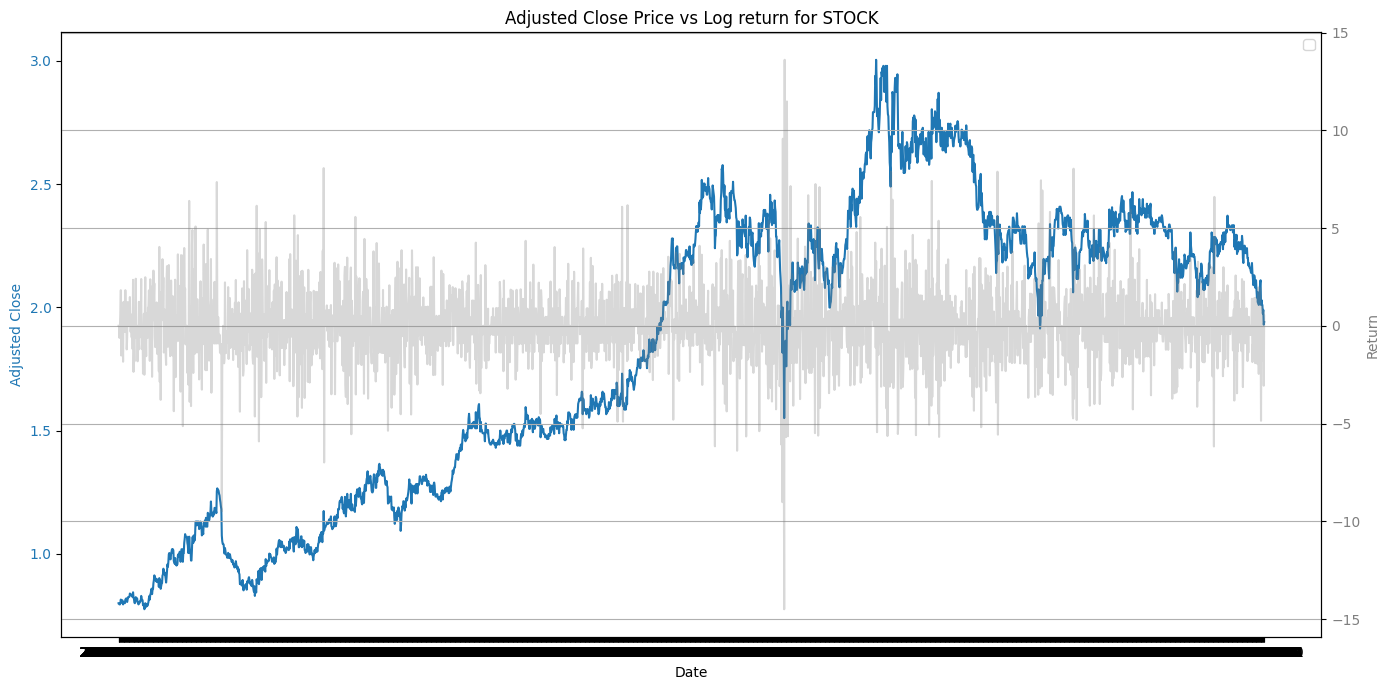

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the Adjusted Close price on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close', color=color)
ax1.plot(STKdates, STKdata['Adj Close'][2:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis to plot the Volume
ax2 = ax1.twinx()
color = 'tab:grey'
ax2.set_ylabel('Return', color=color)
ax2.plot(STKdates, STKr[1:], color=color, alpha=0.3)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Adjusted Close Price vs Log return for STOCK')
plt.grid(True)
plt.tight_layout()
plt.legend()

# Show plot
plt.show()

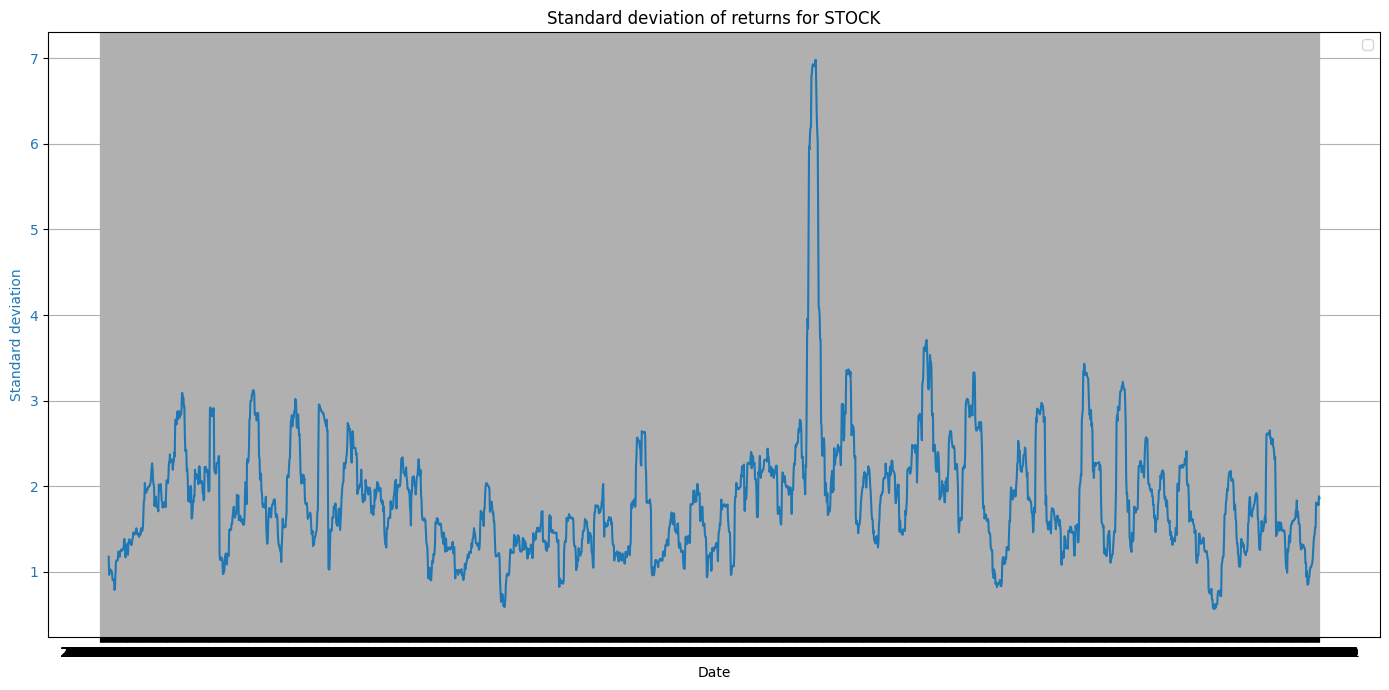

In [ ]:
# prompt: plot the standard deviation of returns

import matplotlib.pyplot as plt
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the Standard deviation of returns on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Standard deviation', color=color)
ax1.plot(STKdates, STKr.rolling(window=20).std()[1:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Standard deviation of returns for STOCK')
plt.grid(True)
plt.tight_layout()
plt.legend()

# Show plot
plt.show()


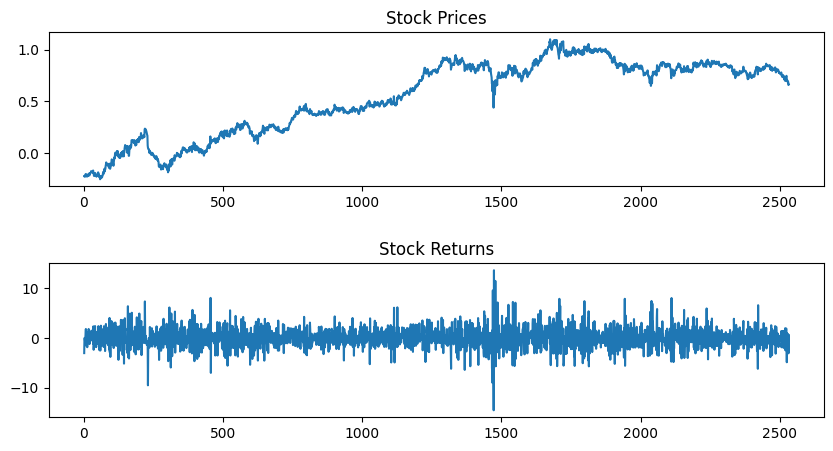

In [ ]:
fig, axs = plt.subplots( 2, 1 )
axs[0].plot( np.log( STKp ) )
axs[0].set_title( 'Stock Prices' )

axs[1].plot( STKr )
axs[1].set_title( 'Stock Returns' )

fig.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
summarise( STKr )

Mean:      0.03377473286452724
Median:    0.0
Stdev:     1.953565275431626
Skewness:  0.1960469265764248
Kurtosis:  7.203989860234264
Min:       -14.497459987788147
Max:       13.608610559600725


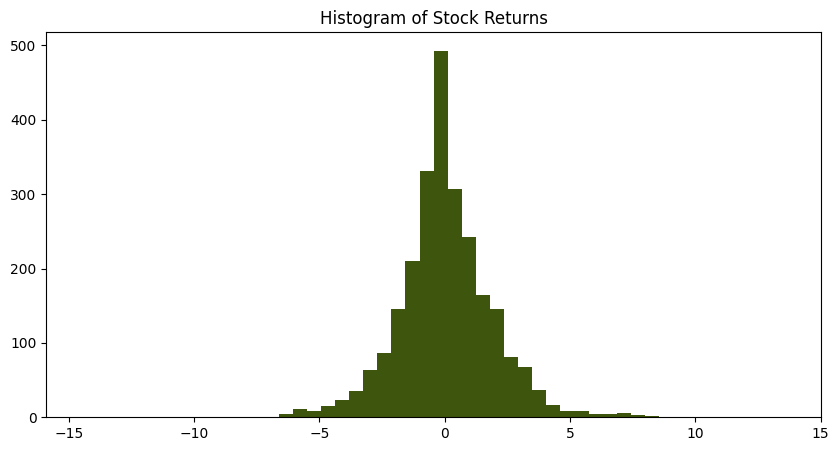

<Figure size 1000x500 with 0 Axes>

In [ ]:
#Histogram
fig, ax = plt.subplots()
ax.hist( STKr, bins = 50, color = "#3D550C" )
ax.set_title( 'Histogram of Stock Returns' )
plt.show()
plt.tight_layout()
plt.show()

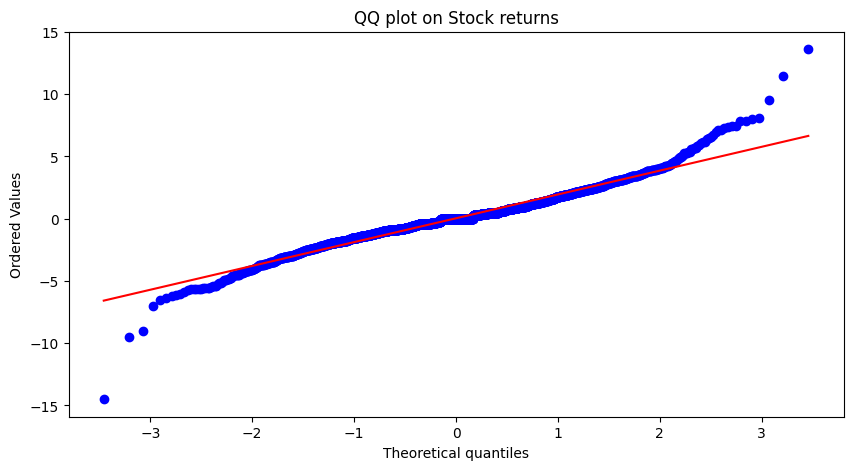

In [ ]:
## qq plot
fig, ax = plt.subplots()
st.probplot( STKr, plot=ax )
ax.set_title( 'QQ plot on Stock returns' )
plt.show()

In [ ]:
#Jarque-Bera test for gaussianity
JB_test_stat, JB_pvalue, _, _ = jarque_bera( STKr )
print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )


JB test statistic: 1880.776809. P-value 0.000000


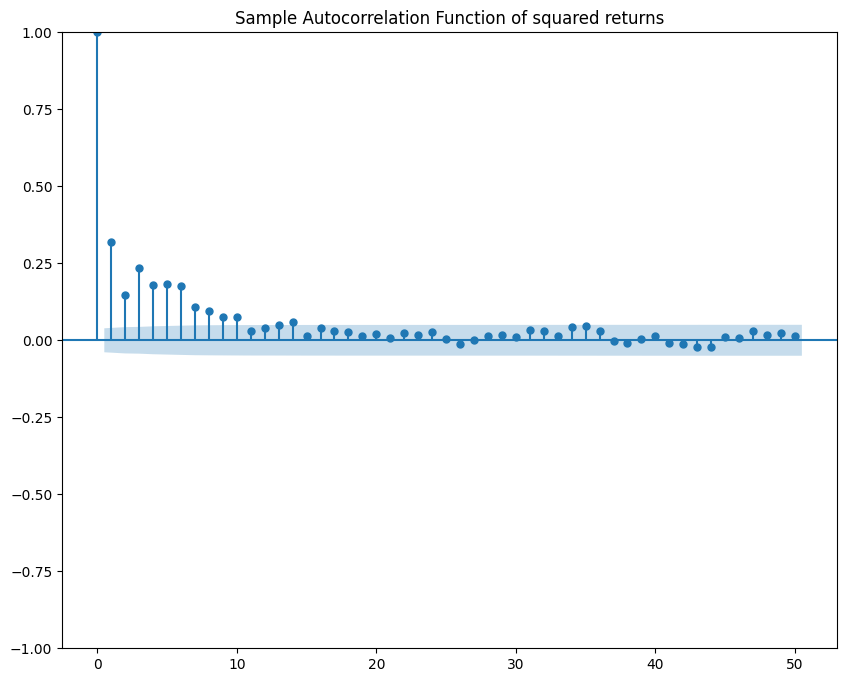

In [ ]:
## ACF Plot forautocorrelation in returns-squared.
fig, ax = plt.subplots(figsize = (10,8))
sm.graphics.tsa.plot_acf( STKr**2, ax=ax, lags=50 )
ax.set_title( 'Sample Autocorrelation Function of squared returns' )
plt.show()
## ACF Plot shows substantial autocorrelation in returns-squared.

In [ ]:
## Ljung-Box test for autocorrelation
## H0: There is no autocorrelation.

from statsmodels.stats.diagnostic import acorr_ljungbox
print( "Ljung-Box Q-statistic:" )
for p in [ 5, 10 ]:
    ljung_box_result = sm.stats.acorr_ljungbox(STKr**2, lags=[p], return_df=True)
    print(ljung_box_result)
print()
## Ljung-Box test. NH is no autocorrelation; strongly rejected.

Ljung-Box Q-statistic:
      lb_stat      lb_pvalue
5  618.168589  2.398732e-131
       lb_stat      lb_pvalue
10  779.722698  4.712638e-161



In [ ]:

## ARCH test on mean-corrected returns
## H0:No ARCH effects;
from statsmodels.stats.diagnostic import het_arch
print( "Engle ARCH statistic:")
a=STKr-STKr.mean()
for p in [ 5, 10 ]:
    Teststat, pValue, _, _ = het_arch( resid=a, nlags=p )
    print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )
## NH is no ARCH effects; strongly rejected.

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 377.816348. P-value: 0.000000
maxlag: 10. ARCH test statistic: 386.619588. P-value: 0.000000


# Model Building

## Garch Model

In [ ]:
# USe AIC and SIC to select optimal GARCH order
aic = np.zeros( ( 6, 6 ) )
sic = np.zeros( ( 6, 6 ) )

for p in range( 1, 6 ):
    for q in range( 0, 6 ):
        Mdl = arch_model( STKris, mean = 'Constant', lags = 1, vol = 'GARCH', p = p, q = q, dist = 'studentst')
        EstMdl = Mdl.fit(disp='off')
        aic[ p, q ] = -2 * EstMdl.loglikelihood + 2 * ( p + q )
        sic[ p, q ] = -2 * EstMdl.loglikelihood + np.log( len( STKr ) ) * ( p + q )

In [ ]:
## AIC favours GARCH( 1, 1 ).
## SIC favours GARCH( 1, 1 ).
with np.printoptions( precision = 2, suppress = True ):
    print( aic )
    print( sic )

[[   0.      0.      0.      0.      0.      0.  ]
 [9412.77 9378.91 9367.77 9367.42 9366.14 9368.14]
 [9398.94 9380.91 9369.77 9369.42 9368.12 9370.12]
 [9387.1  9382.91 9371.77 9371.42 9370.12 9372.12]
 [9388.21 9384.91 9373.77 9373.42 9372.12 9374.12]
 [9386.52 9385.79 9375.77 9375.42 9374.12 9376.12]]
[[   0.      0.      0.      0.      0.      0.  ]
 [9418.61 9390.58 9385.28 9390.76 9395.32 9403.16]
 [9410.61 9398.42 9393.11 9398.6  9403.14 9410.98]
 [9404.61 9406.26 9400.95 9406.44 9410.98 9418.82]
 [9411.56 9414.09 9408.79 9414.28 9418.82 9426.65]
 [9415.7  9420.82 9416.62 9422.11 9426.65 9434.49]]


In [ ]:
Mdlg = arch_model( STKris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst' )
EstMdlg = Mdlg.fit( disp = 'off' )
print( EstMdlg.summary() )

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4687.46
Distribution:      Standardized Student's t   AIC:                           9384.91
Method:                  Maximum Likelihood   BIC:                           9413.68
                                              No. Observations:                 2332
Date:                      Fri, May 31 2024   Df Residuals:                     2331
Time:                              23:29:22   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [ ]:
averate_vol = EstMdlg.params['omega']/(1-EstMdlg.params['alpha[1]']- EstMdlg.params['beta[1]'])
sample_var = np.var(STKris)
print(averate_vol, sample_var)

4.145154891168724 3.906544395470333


In [ ]:
sG = EstMdlg.conditional_volatility #infer the conditional standard deviations
vG = sG**2 #Conditional variance
aG = STKris - EstMdlg.params['mu'] #Calculate innovations
eG = aG / sG ## Standardised residuals

#Transform stardardise residual
dfg = EstMdlg.params['nu']

#Asess fit to data
eG1 = np.sqrt(dfg)/np.sqrt(dfg-2)*eG #this should have a Student-t with df degrees of freedom
# Calculating Gaussian residuals, (Trabsformed standardised residuals)
eGG11 = stats.norm.ppf(stats.t.cdf(eG1,dfg))

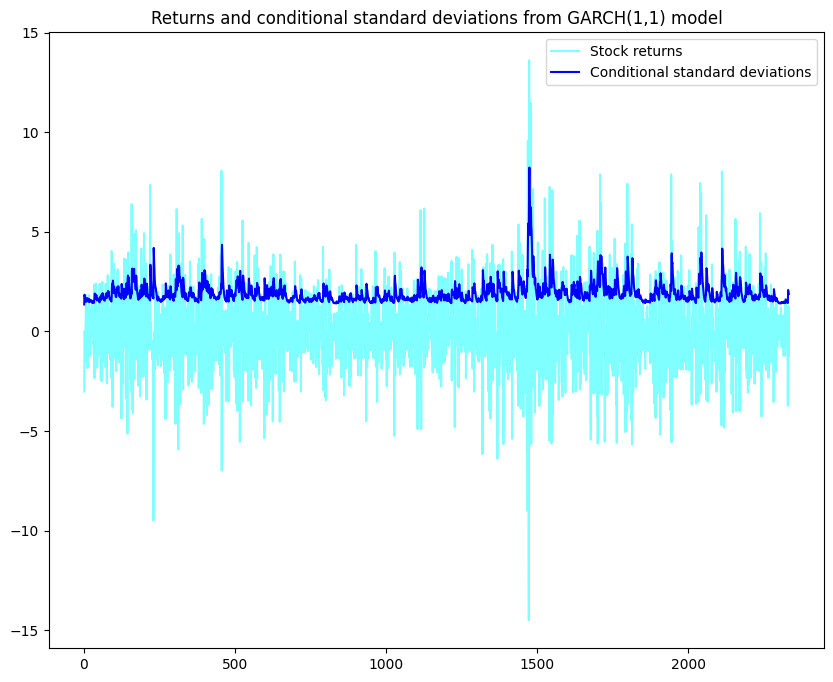

In [ ]:
fig = plt.figure(figsize= (10,8))
plt.plot( STKris, color = 'cyan', alpha = 0.5, label = 'Stock returns' )
plt.plot( sG, color = 'blue', label = 'Conditional standard deviations' )
plt.title( 'Returns and conditional standard deviations from GARCH(1,1) model' )
plt.legend()
plt.show()

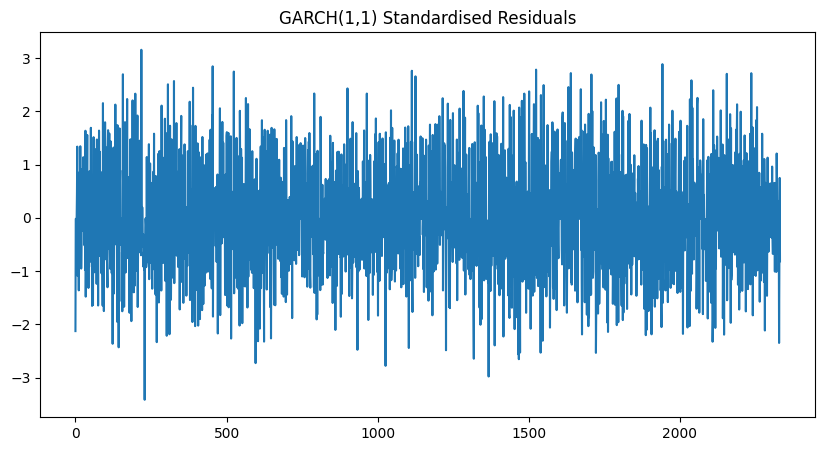

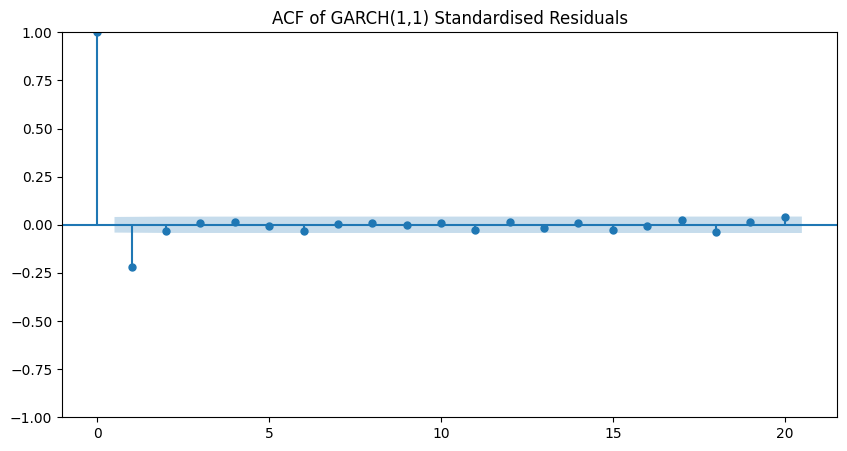

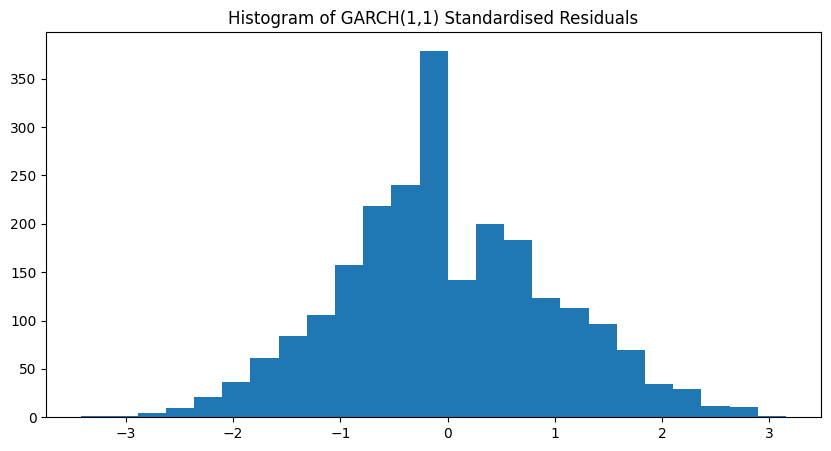

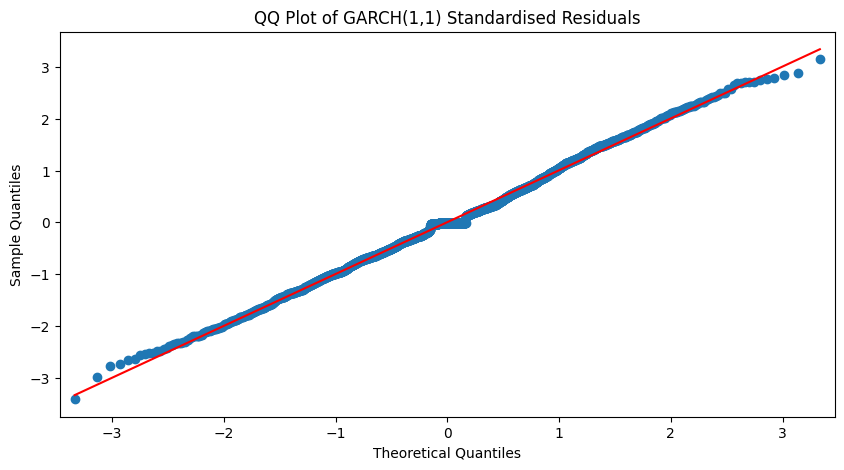

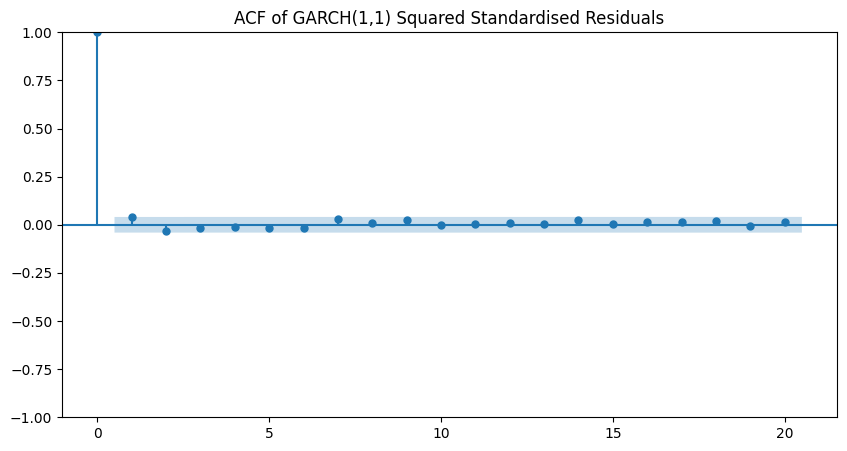

In [ ]:
assess_fit_plots( eGG11, 'GARCH(1,1)' )

In [ ]:
assess_fit_stats( eGG11, 2 )

Ljung-Box Q-statistic on standardised residuals:
      lb_stat     lb_pvalue
7  116.053922  2.148805e-23
       lb_stat     lb_pvalue
12  118.670195  9.416612e-21

Ljung-Box Q-statistic on squared standardised residuals:
     lb_stat  lb_pvalue
7  10.335232   0.066275
      lb_stat  lb_pvalue
12  12.438523   0.256779

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 7.582503. P-value: 0.180795
maxlag: 10. ARCH test statistic: 12.186684. P-value: 0.272757

Skewness: 0.103945
Kurtosis: 2.927102
JB test statistic: 4.715713. P-value 0.094623



## AR-EGARCH model

In [ ]:
#Fit AR(1)-EGARCH(1,0)-Gaussian model (Standard EGARCH)
Mdl = arch_model(y = STKris, x=None, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, o = 1, q = 1,dist = 'studentst')
EstMdlEG10 = Mdl.fit(disp='off')
seg = EstMdlEG10.conditional_volatility #infer the conditional standard deviations
veg = seg**2 #Conditional variance
aeg = STKris - EstMdlEG10.params['Const'] #Calculate innovations
eeg= aeg / seg
print(EstMdlEG10.summary())

                             AR - EGARCH Model Results                              
Dep. Variable:                    Adj Close   R-squared:                       0.063
Mean Model:                              AR   Adj. R-squared:                  0.062
Vol Model:                           EGARCH   Log-Likelihood:               -4609.27
Distribution:      Standardized Student's t   AIC:                           9232.54
Method:                  Maximum Likelihood   BIC:                           9272.81
                                              No. Observations:                 2331
Date:                      Fri, May 31 2024   Df Residuals:                     2329
Time:                              23:29:24   Df Model:                            2
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------

In [ ]:
uc_vol_eg = np.exp(EstMdlEG10.params['omega']/(1-EstMdlEG10.params['beta[1]']))
print(uc_vol_eg,sample_var)

4.125692940829463 3.906544395470333


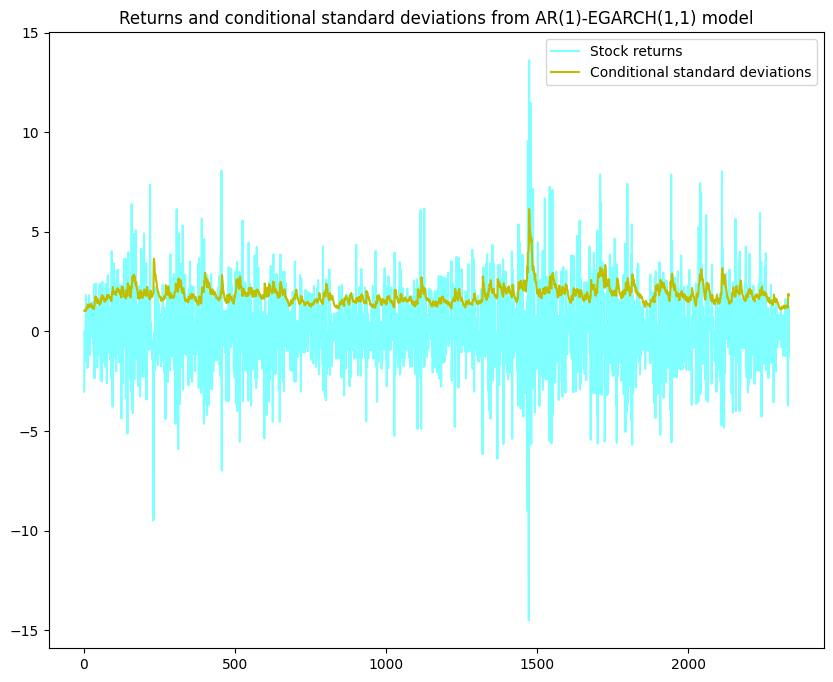

In [ ]:
fig = plt.figure(figsize= (10,8))
plt.plot( STKris, color = 'cyan', alpha = 0.5, label = 'Stock returns' )
plt.plot( seg, color = 'y', label = 'Conditional standard deviations' )
plt.title( 'Returns and conditional standard deviations from AR(1)-EGARCH(1,1) model' )
plt.legend()
plt.show()

In [ ]:
#asymmetry measures for +2 vs -2 standardised shocks
Gama = EstMdlEG10.params['alpha[1]'] #parameter in front of |e(t-1)|
Thet = EstMdlEG10.params['gamma[1]'] #asymmetric parameter, in front of e(t-1)
Asym = np.exp((Thet+Gama)*(-2))/np.exp((Thet-Gama)*2) # The level of asymmetry can be estimated this equation:
print('\nA shock of minus two standard errors gives a {} percent increase in volatility, compared with the same magnitude positive shock.'.format((np.exp(-2*2*Thet)-1)*100))



A shock of minus two standard errors gives a 28.354858493228253 percent increase in volatility, compared with the same magnitude positive shock.


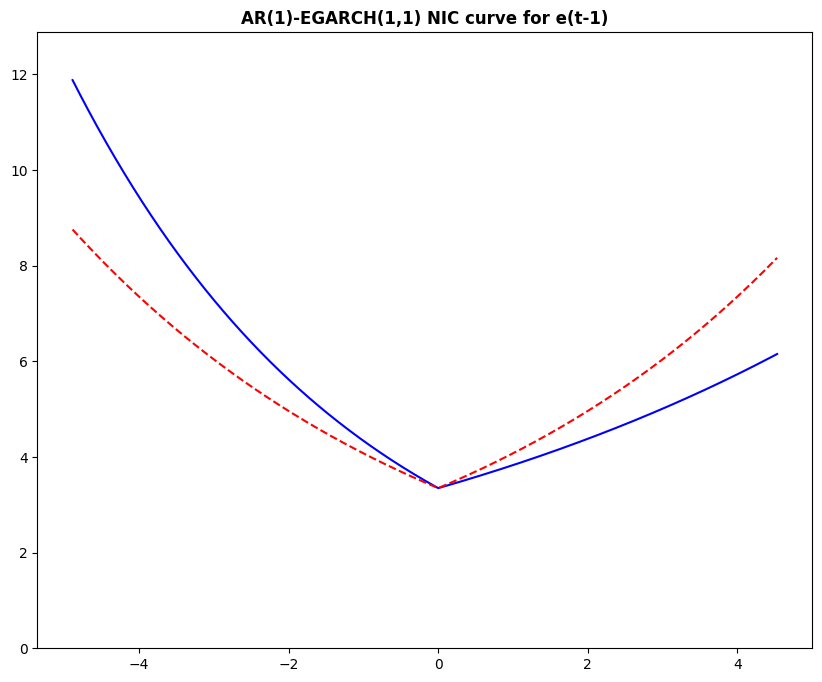

In [ ]:
#NIC curve for AR(1)-EGARCH(1,0)
b1 = EstMdlEG10.params['beta[1]']
a0 = EstMdlEG10.params['omega']

e = np.arange(eeg.min(), eeg.max(), 0.01)
sg = np.var(aeg)
sigte = np.exp(a0 + Gama * (abs(e) - np.sqrt(2/np.pi)) + b1 * np.log(sg) + Thet * e)
sigt2e = np.exp(a0 + Gama * (abs(e) - np.sqrt(2/np.pi)) + b1 * np.log(sg))

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(e, sigte, c = 'b')
axs.plot(e, sigt2e, c = 'r', ls = '--')
axs.set_title('AR(1)-EGARCH(1,1) NIC curve for e(t-1)', weight = 'bold')
axs.set_ylim(0, sigte.max()+1)
plt.show()

In [ ]:
dfeg = EstMdlEG10.params['nu']

#Asess fit to data
eeg11 = np.sqrt(dfeg)/np.sqrt(dfeg-2)*eeg #this should have a Student-t with df degrees of freedom
# Calculating Gaussian residuals, (Trabsformed standardised residuals)
eegg11 = stats.norm.ppf(stats.t.cdf(eeg11,dfeg))

In [ ]:
dfeg

5.753320091342979

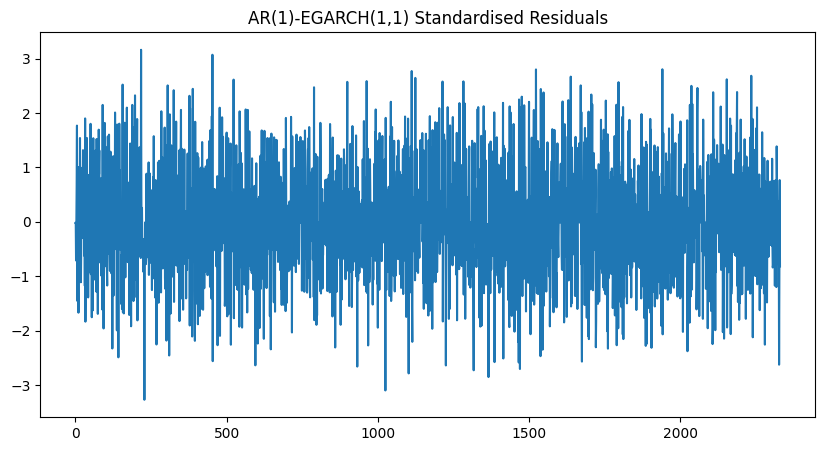

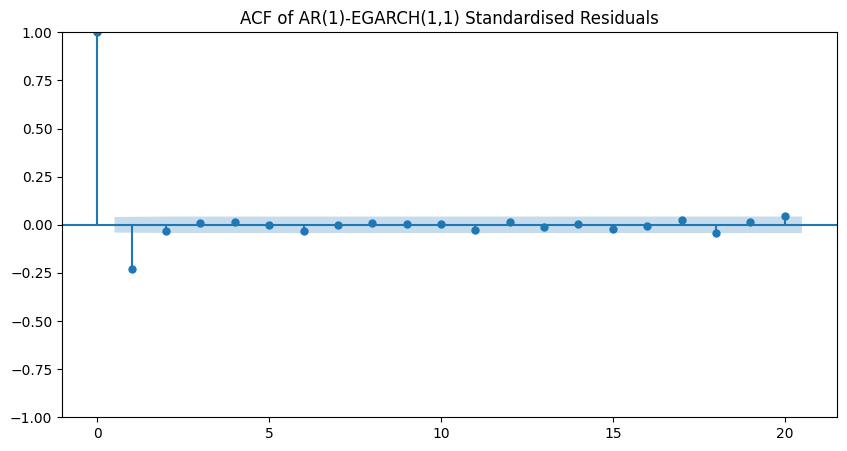

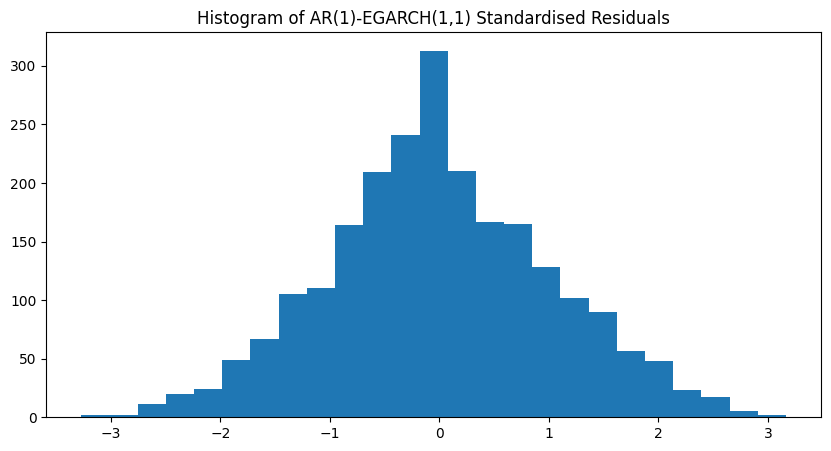

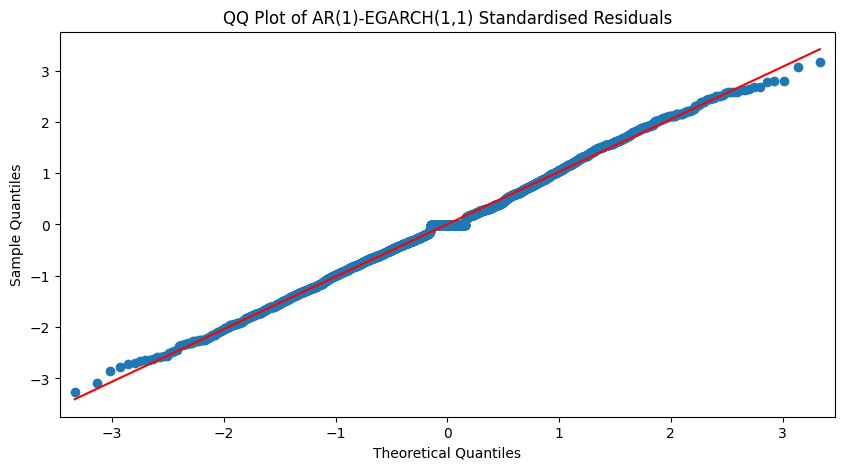

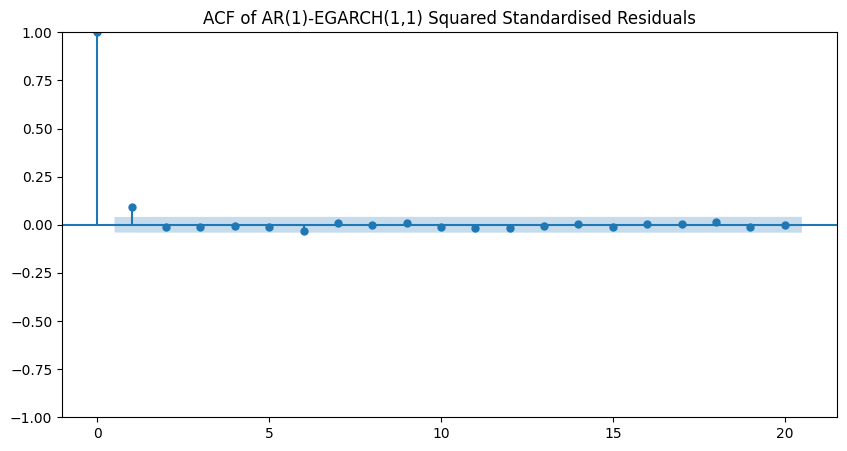

In [ ]:
assess_fit_plots( eegg11[1:], 'AR(1)-EGARCH(1,1)' )

In [ ]:
eegg11

array([        nan, -0.01779454, -0.01688959, ..., -0.85896819,
        0.76837043, -0.81661799])

In [ ]:
assess_fit_stats( eegg11[1:], 3)

Ljung-Box Q-statistic on standardised residuals:
      lb_stat     lb_pvalue
8  129.767083  2.666874e-26
       lb_stat     lb_pvalue
13  132.598815  1.377062e-23

Ljung-Box Q-statistic on squared standardised residuals:
     lb_stat  lb_pvalue
8  23.767917   0.000241
      lb_stat  lb_pvalue
13  25.588021   0.004336

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 21.438683. P-value: 0.000669
maxlag: 10. ARCH test statistic: 24.471118. P-value: 0.006443

Skewness: 0.065272
Kurtosis: 2.916941
JB test statistic: 2.325212. P-value 0.312670



## EGARCH(1,1)

In [ ]:
# EGARCH-N
egarch_n = arch_model(STKris, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='normal')
egarch_n_fit = egarch_n.fit( disp= 'off' )
sen = EstMdlEG10.conditional_volatility #infer the conditional standard deviations
ven = seg**2 #Conditional variance
aen = STKris - EstMdlEG10.params['Const'] #Calculate innovations
een= aen / sen
print(egarch_n_fit.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4736.03
Distribution:                  Normal   AIC:                           9482.06
Method:            Maximum Likelihood   BIC:                           9510.84
                                        No. Observations:                 2332
Date:                Fri, May 31 2024   Df Residuals:                     2331
Time:                        23:29:26   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0198  3.762e-02      0.526      0.599 

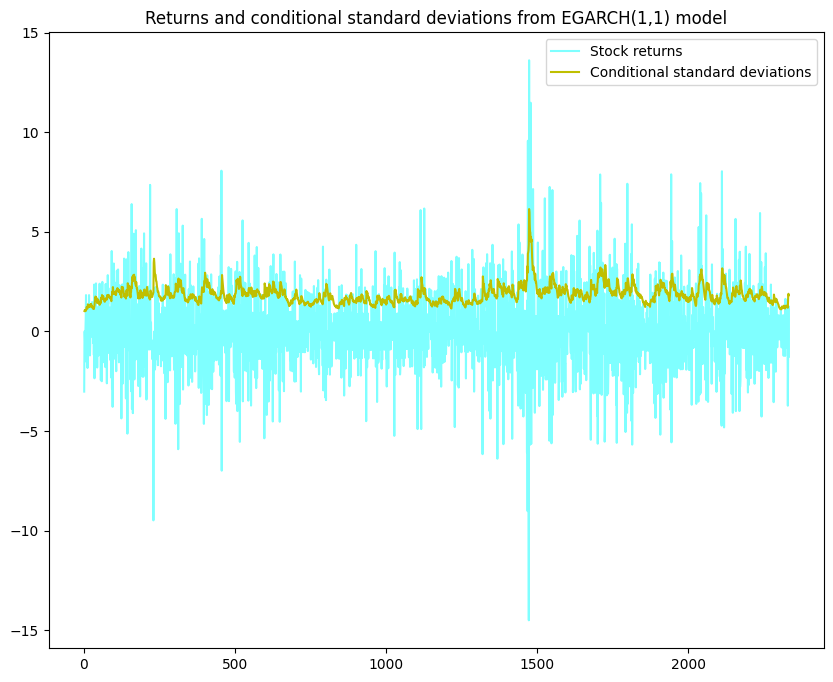

In [ ]:
fig = plt.figure(figsize= (10,8))
plt.plot( STKris, color = 'cyan', alpha = 0.5, label = 'Stock returns' )
plt.plot( sen, color = 'y', label = 'Conditional standard deviations' )
plt.title( 'Returns and conditional standard deviations from EGARCH(1,1) model' )
plt.legend()
plt.show()

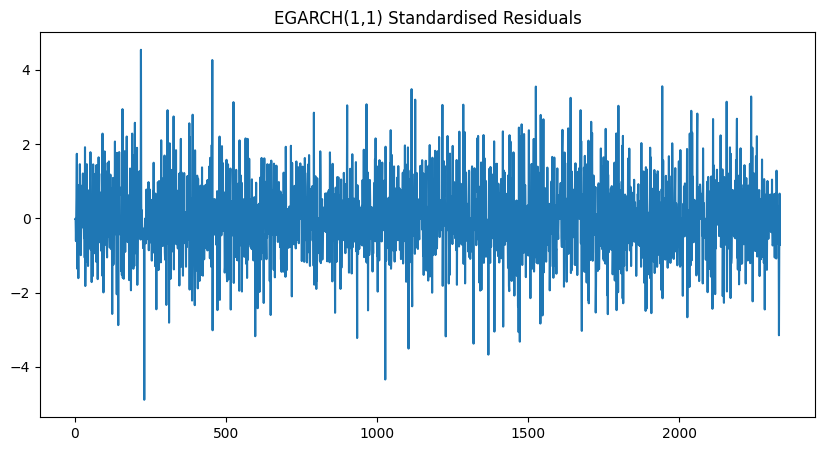

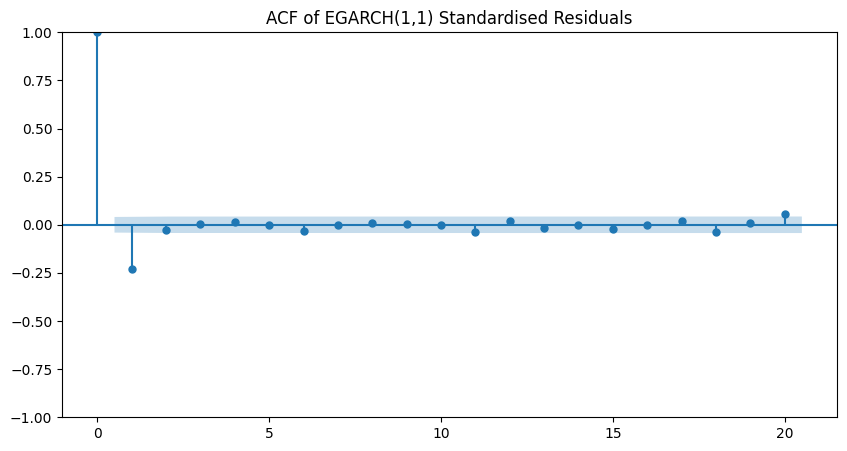

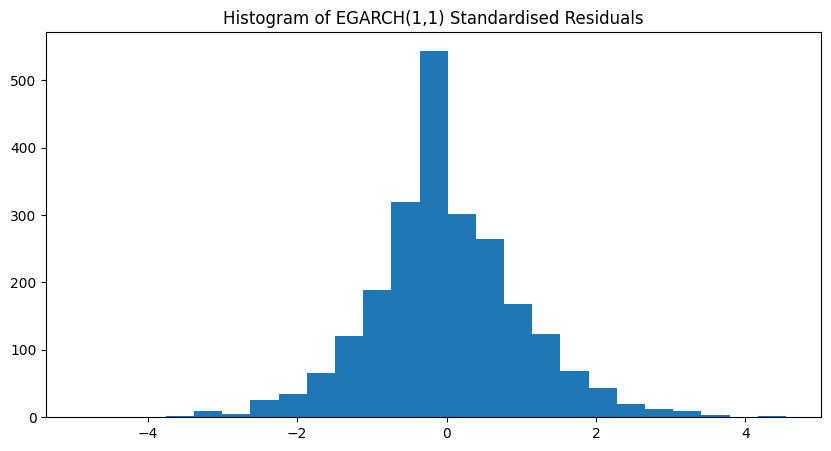

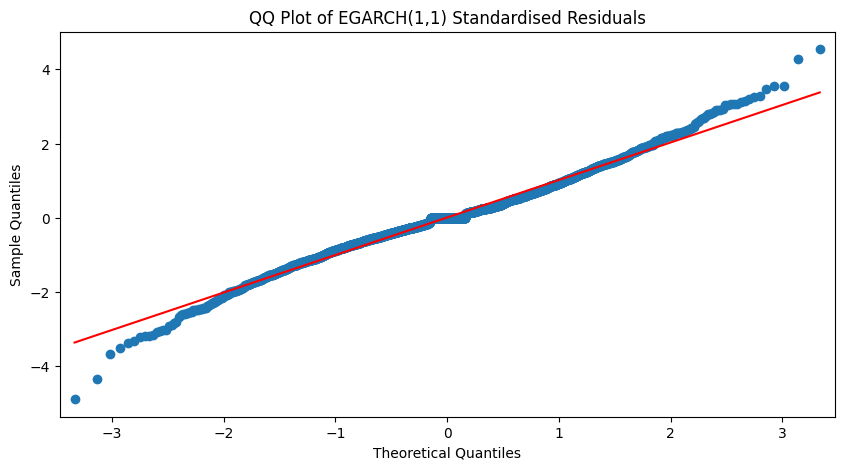

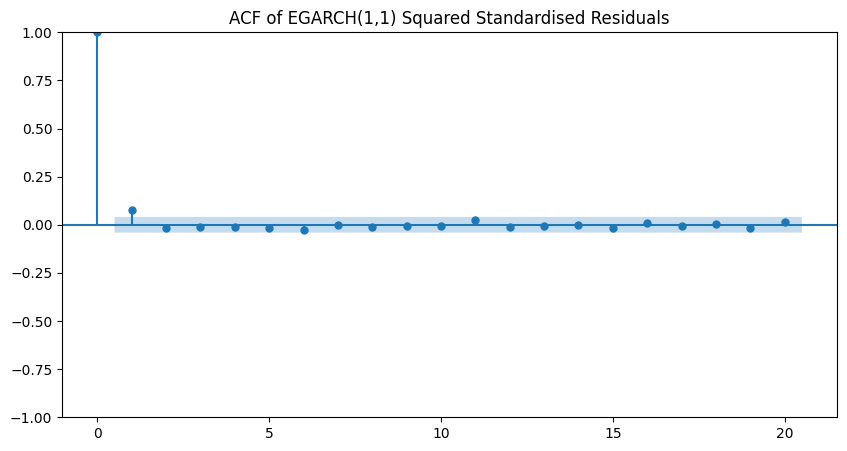

In [ ]:
assess_fit_plots( een[1:], 'EGARCH(1,1)' )

## IGARCH - Risk Metrics


In [ ]:
# IGARCH(1,1) = Risk model
rm = arch_model(STKris, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal')
rm_fit = rm.fix(params = [0, 0.06, 0.94])
srm = rm_fit.conditional_volatility #infer the conditional standard deviations
vrm = srm**2 #Conditional variance
arm = STKris  #Calculate innovations
erm= arm / srm
print(rm.fit(disp = 'off').summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5130.68
Distribution:                  Normal   AIC:                           10267.4
Method:            Maximum Likelihood   BIC:                           10284.9
                                        No. Observations:                 2531
Date:                Sat, Jun 01 2024   Df Residuals:                     2531
Time:                        00:21:34   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3636      0.235      1.546      0.122 [-9.74

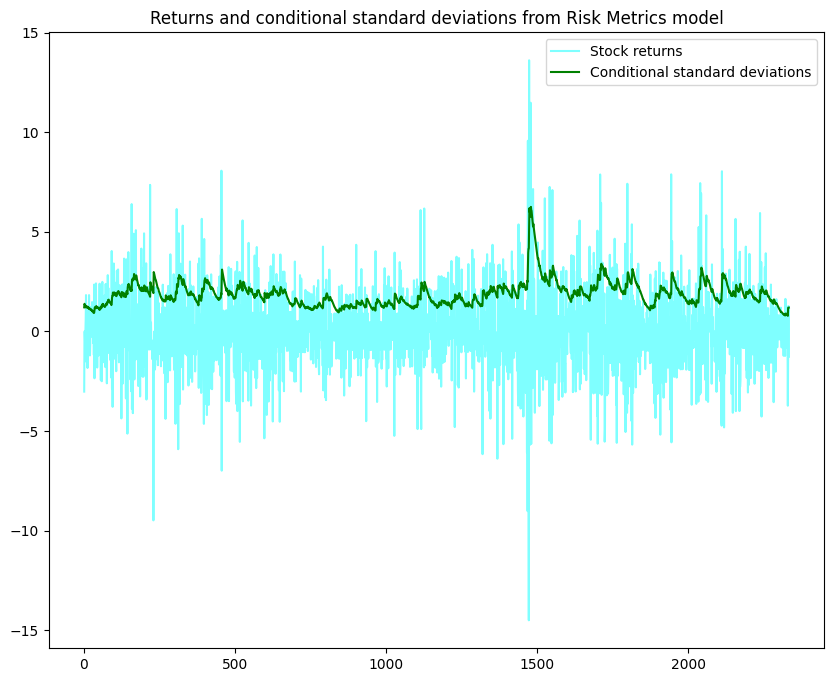

In [ ]:
fig = plt.figure(figsize= (10,8))
plt.plot( STKris, color = 'cyan', alpha = 0.5, label = 'Stock returns' )
plt.plot( srm, color = 'g', label = 'Conditional standard deviations' )
plt.title( 'Returns and conditional standard deviations from Risk Metrics model' )
plt.legend()
plt.show()


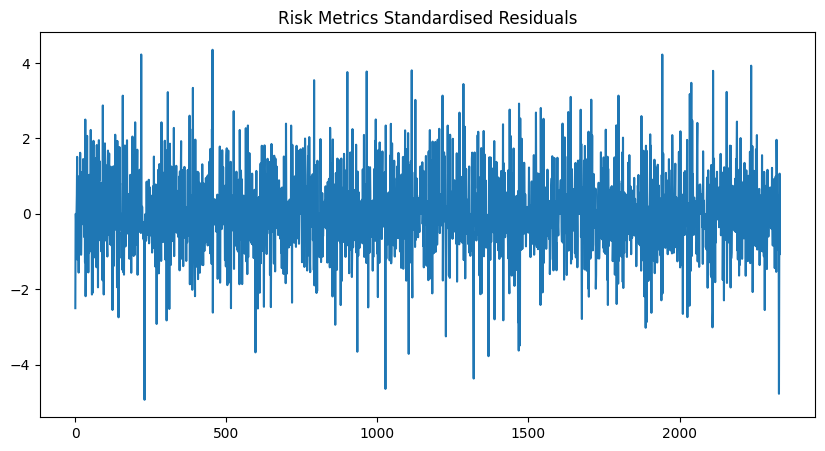

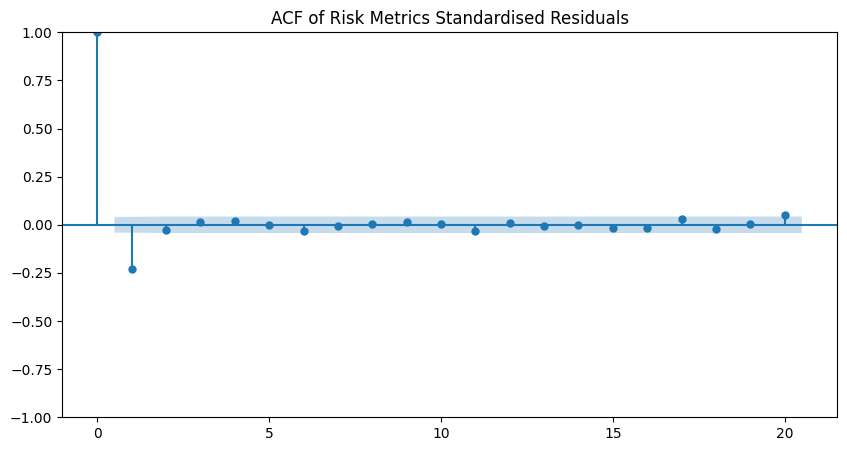

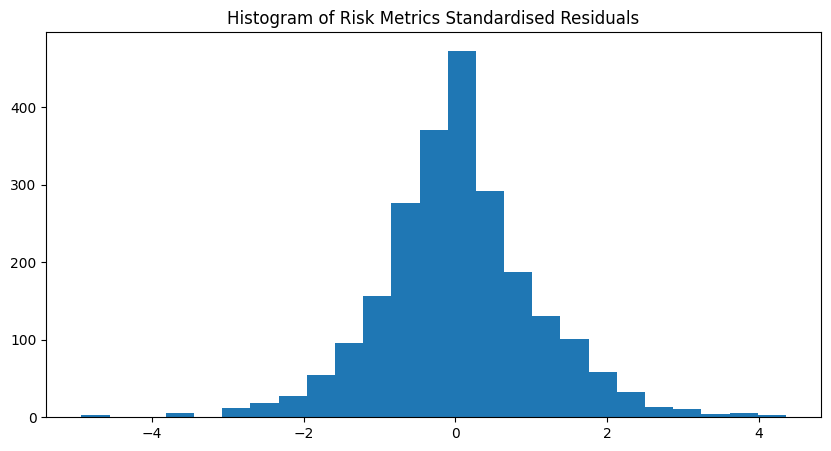

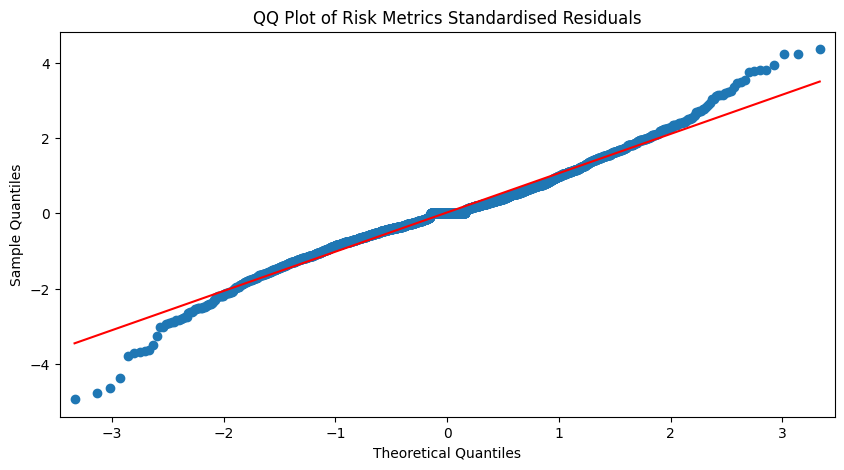

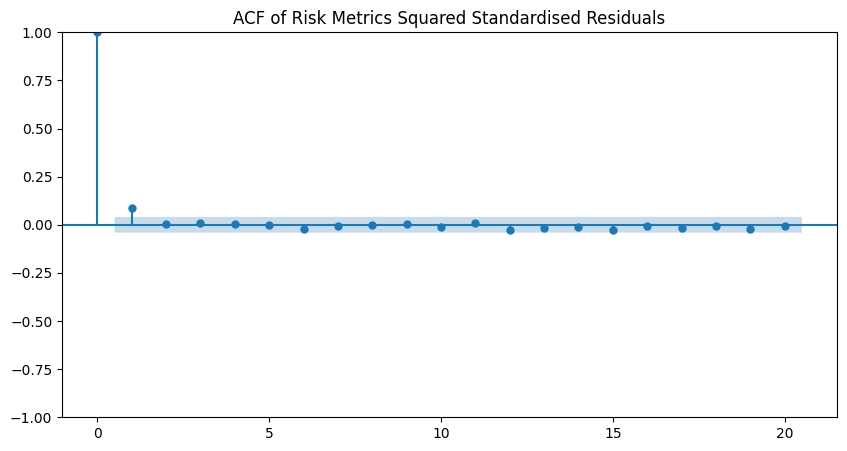

In [ ]:
assess_fit_plots( erm, 'Risk Metrics' )

In [ ]:
assess_fit_stats( erm, 2)

Ljung-Box Q-statistic on standardised residuals:
      lb_stat     lb_pvalue
7  146.078824  9.119566e-30
       lb_stat     lb_pvalue
12  148.388341  7.996049e-27

Ljung-Box Q-statistic on squared standardised residuals:
     lb_stat  lb_pvalue
7  23.855866   0.000231
      lb_stat  lb_pvalue
12  26.905343   0.002696

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 23.310923. P-value: 0.000294
maxlag: 10. ARCH test statistic: 24.744183. P-value: 0.005852

Skewness: 0.037999
Kurtosis: 4.656344
JB test statistic: 289.931582. P-value 0.000000



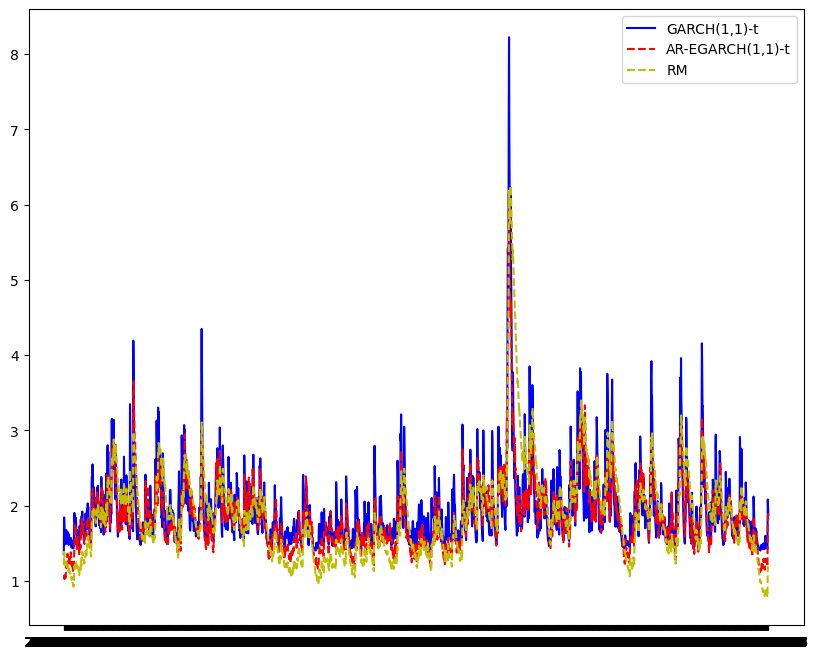

In [ ]:
#Plot conditional standard deviations for GARCH(1,1)-t and GJR-GARCH(1,1)-t model for comparison
fig, axs = plt.subplots(1,1, figsize = (10,8))
axs.plot(STKdates[1:nis+1], sG, c = 'b', label = 'GARCH(1,1)-t')
axs.plot(STKdates[1:nis+1], seg, c = 'r', label = 'AR-EGARCH(1,1)-t', ls ='--')
axs.plot(STKdates[1:nis+1], srm, c = 'y', label = 'RM', ls ='--')

axs.set_title('', weight = 'bold')
axs.legend()
plt.show()

##Combination

# Forecast - Hold-out

##Proxies

In [ ]:
closeC = STKdata['Close']
highC = STKdata['High']
lowC = STKdata['Low']
openC = STKdata['Open']
rangC = 100 * np.log( highC / lowC )

In [ ]:
prox1C = abs( STKr - STKr.mean() )
prox2C = np.sqrt(0.3607*(rangC**2))[1:]
prox3C = np.sqrt( 1.107*prox2C**2 + 0.68*((100*np.log(np.divide(openC[1:], closeC[:-1])))**2) )[1:]
prox4C = np.sqrt( np.exp(2*np.log(rangC)-0.86+2*0.29**2) )[1:]

assert( len(prox1C) == len( STKr ) )
assert( len(prox2C) == len( STKr ) )
assert( len(prox3C) == len( STKr ) )
assert( len(prox4C) == len( STKr ) )

## in-sample proxies
prox1Ci = prox1C[:nis]
prox2Ci = prox2C[:nis]
prox3Ci = prox3C[:nis]
prox4Ci = prox4C[:nis]

## forecast-sample proxies
prox1Cf = prox1C[nis:]
prox2Cf = prox2C[nis:]
prox3Cf = prox3C[nis:]
prox4Cf = prox4C[nis:]

In [ ]:
#Error Metrics
def mse( a, b ):
    return np.sqrt( np.mean( ( a - b )**2 ) )

def mad( a, b ):
    return np.mean( abs( a - b ) )

def compare_all_proxies( a, measure, name ):
    print( name.ljust(16), end = ' ' )
    for i in [ prox1Cf, prox2Cf, prox3Cf, prox4Cf ]:
        print( '%f' % measure( a, i ), end = ' ' )
    print()

## In-Sample forecast

In [ ]:
## Initialise vectors for keeping forecast results
sigGf = []
sigEGf = []
sigRMf = []

for t in range( nis, n ):
    STKris = STKr[:t]

    ## GARCH(1,1)-t
    Mdlg = arch_model( STKris, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst' )
    ## AR-EGARCH(1,1)-t
    Mdleg = arch_model(y = STKris, x=None, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, q = 1, o = 1, dist = 'studentst')
    ## Risk Metrics
    Mdlrm = arch_model(STKris, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
    EstMdlrm = Mdlrm.fix(params = [0, 0.06, 0.94])

    if t % 25 == nis % 25:
        ## Re-estimate models every 25 days
        EstMdlg = Mdlg.fit( disp = 'off' )
        EstMdleg = Mdleg.fit( disp = 'off' )
    else:
        ## Fix the model using previously computed params.
        EstMdlg = Mdlg.fix( params = EstMdlg.params )
        EstMdleg = Mdleg.fix( params = EstMdleg.params )

    sigGf.append( np.sqrt( EstMdlg.forecast( horizon = 1 ).variance.values[-1, 0] ) )
    sigEGf.append( np.sqrt( EstMdleg.forecast( horizon = 1, method='simulation', simulations=10000 ).variance.values[-1, 0] ) )
    sigRMf.append( np.sqrt( EstMdlrm.forecast( horizon = 1 ).variance.values[-1, 0] ) )



## Check that the correct number of forecasts were generated.
assert( len(sigGf) == nf )
assert( len(sigEGf) == nf )
assert( len(sigRMf) == nf )

In [ ]:
type(sigGf)

list

In [ ]:
assert len(sigGf) == len(sigEGf) == len(sigRMf), "Lists must be of the same length"

# Combine the lists and calculate the average
combf = [(g + e + r) / 3 for g, e, r in zip(sigGf, sigEGf, sigRMf)]

# Print the result
print(combf)
assert len(sigGf) == len(sigEGf) == len(sigRMf) == len(combf)

[1.6094830202994883, 1.5423183141298695, 1.8774991039923339, 2.0909018067013396, 1.9755802589250253, 1.8358639617699828, 2.0982257527508037, 2.1091562672486663, 2.291891153621564, 2.230808002273303, 2.0661420363631398, 2.1089394884749386, 2.064534632760521, 2.0890039874131263, 2.018735418303073, 1.9189904308028478, 1.8369230269471224, 1.8422821643568128, 1.7438300487445242, 1.8634582287431447, 1.7608921931048942, 1.668825182283201, 1.6565249313820003, 1.5963774474699886, 1.680437735169539, 1.592529605092306, 1.5724038774972495, 1.6140109227427637, 1.5493186624050368, 1.4945991974746897, 1.4743738831734063, 1.4313408595040171, 1.4482506127515051, 1.395566135240193, 1.4052199637937417, 1.3609354914986322, 1.4312653264115298, 1.7213238705983631, 1.765615334761731, 1.7286372745889784, 1.7296223292564321, 1.6329250627601617, 1.5655230016748067, 1.494309922486809, 1.4426565094682624, 1.4054268495285136, 1.3576674593813862, 1.3729300003934728, 1.443067065927974, 1.4209912834967575, 1.47605703

In [ ]:
len(sigGf)

200

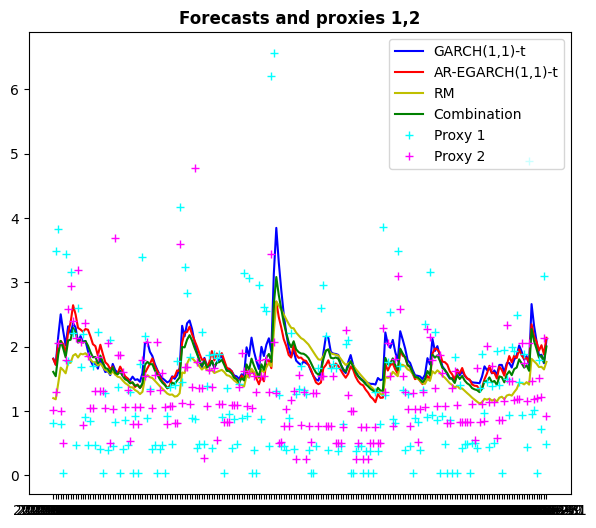

In [ ]:
# prompt: Plot all the forecast above on test set

import matplotlib.pyplot as plt
fig, axs = plt.subplots( 1, 1, figsize = (7,6) )
axs.plot( STKdates[nis-1:], sigGf, c = 'b', label = 'GARCH(1,1)-t' )
axs.plot( STKdates[nis-1:], sigEGf, c = 'r', label = 'AR-EGARCH(1,1)-t')
axs.plot( STKdates[nis-1:], sigRMf, c = 'y', label = 'RM')
axs.plot( STKdates[nis-1:], combf, c = 'g', label = 'Combination' )
axs.plot( STKdates[nis-1:], prox1Cf, c = 'cyan',marker = '+', label = 'Proxy 1', ls = '' )
axs.plot( STKdates[nis-1:], prox2Cf, c = 'magenta',marker = '+', label = 'Proxy 2', ls = '' )

#axs.plot( STKdates[nis:], prox2Cf, c = 'm', label = 'Proxy 2', ls = '--' )


axs.set_title( 'Forecasts and proxies 1,2', weight = 'bold' )
axs.legend()
plt.show()


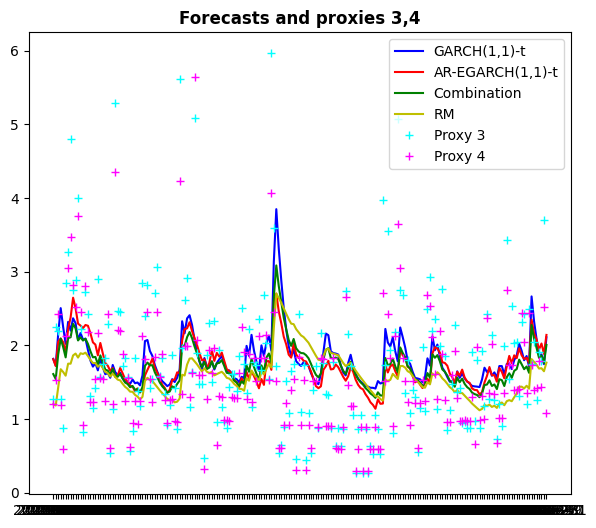

In [ ]:
# prompt: Plot all the forecast above on test set

import matplotlib.pyplot as plt
fig, axs = plt.subplots( 1, 1, figsize = (7,6) )
axs.plot( STKdates[nis-1:], sigGf, c = 'b', label = 'GARCH(1,1)-t' )
axs.plot( STKdates[nis-1:], sigEGf, c = 'r', label = 'AR-EGARCH(1,1)-t')
axs.plot( STKdates[nis-1:], combf, c = 'g', label = 'Combination' )

axs.plot( STKdates[nis-1:], sigRMf, c = 'y', label = 'RM')
axs.plot( STKdates[nis-1:], prox3Cf, c = 'cyan',marker = '+', label = 'Proxy 3', ls = '' )
axs.plot( STKdates[nis-1:], prox4Cf, c = 'magenta',marker = '+', label = 'Proxy 4', ls = '' )

#axs.plot( STKdates[nis:], prox2Cf, c = 'm', label = 'Proxy 2', ls = '--' )


axs.set_title( 'Forecasts and proxies 3,4', weight = 'bold' )
axs.legend()
plt.show()


In [ ]:
print( "MSE for all 4 proxies over forecast-sample for all model forecasts:" )
compare_all_proxies( sigGf, mse, 'GARCH(1,1)-t' )
compare_all_proxies( sigEGf, mse, 'AR1-EGARCH(1,1)-t' )
compare_all_proxies( sigRMf, mse, 'Risk Metrics-n' )
compare_all_proxies( combf, mse, 'Combination' )
print()

MSE for all 4 proxies over forecast-sample for all model forecasts:
GARCH(1,1)-t     1.218158 0.850083 0.980553 0.839382 
AR1-EGARCH(1,1)-t 1.192886 0.778480 0.959442 0.787824 
Risk Metrics-n   1.184470 0.786802 1.043508 0.845773 
Combination      1.187428 0.789056 0.981675 0.808427 



In [ ]:
print( "MAD for all 4 proxies over forecast-sample for all model forecasts:" )
compare_all_proxies( sigGf, mad, 'GARCH(1,1)-t' )
compare_all_proxies( sigEGf, mad, 'AR1-EGARCH(1,1)-t' )
compare_all_proxies( sigRMf, mad, 'Risk Metrics-n' )
compare_all_proxies( combf, mad, 'Combination' )
print()

MAD for all 4 proxies over forecast-sample for all model forecasts:
GARCH(1,1)-t     1.018231 0.690123 0.711193 0.642036 
AR1-EGARCH(1,1)-t 0.985869 0.640011 0.689202 0.605479 
Risk Metrics-n   0.960665 0.607649 0.747955 0.621019 
Combination      0.979264 0.636182 0.706033 0.610155 



# Out of Sample Forecast

In [ ]:
## Initialise vectors for keeping forecast results
sigGof = []
sigEGof = []
sigRMof = []
h = 200
## GARCH(1,1)-t
Mdlg = arch_model( STKr, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst' )
EstMdlg = Mdlg.fit( disp = 'off' )

## AR-EGARCH(1,1)-t
Mdleg = arch_model(y = STKr, x=None, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, q = 1, o = 1, dist = 'studentst')
EstMdleg = Mdleg.fit( disp = 'off' )
## Risk Metrics
Mdlrm = arch_model(STKr, mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
EstMdlrm = Mdlrm.fix(params = [0, 0.06, 0.94])

sigGof = np.sqrt( EstMdlg.forecast( horizon = h ).variance.values.reshape(-1) )
sigEGof= np.sqrt( EstMdleg.forecast( horizon = h, method='simulation', simulations=10000 ).variance.values.reshape(-1) )
sigRMof= np.sqrt( EstMdlrm.forecast( horizon = h ).variance.values.reshape(-1) )





In [ ]:
sigEGof

array([1.98473261, 2.0434026 , 2.04831322, 2.05037766, 2.04944945,
       2.05019834, 2.05313516, 2.05016728, 2.04749452, 2.04844081,
       2.04766833, 2.04419394, 2.05837807, 2.05666548, 2.05848158,
       2.05038779, 2.04521099, 2.03637312, 2.03090531, 2.0274321 ,
       2.02546858, 2.02007224, 2.01778946, 2.01435839, 2.01494032,
       2.01374923, 2.01352334, 2.01262985, 2.01198916, 2.00960672,
       2.00850998, 2.00720694, 2.00481795, 2.00588593, 2.00196753,
       1.99790543, 1.99489161, 1.99134187, 1.99028361, 1.9874917 ,
       1.9849061 , 1.98662733, 1.98250391, 1.98122602, 1.98219736,
       1.9814524 , 1.98180328, 1.98795933, 1.98724075, 1.98239323,
       1.98351901, 1.98856188, 1.98852204, 1.98756227, 1.98604612,
       1.98710678, 1.98428681, 1.99046431, 1.98755843, 2.00876838,
       2.00302676, 1.9972545 , 1.99711877, 1.99254414, 1.98978472,
       1.98850709, 1.98792448, 1.98805221, 1.98653471, 1.98677427,
       1.98596088, 1.98660253, 1.98727556, 1.99196886, 1.99166

In [ ]:
## Check that the correct number of forecasts were generated.
assert( len(sigGof) == 200 )
assert( len(sigEGof) == 200 )
assert( len(sigRMof) == 200 )

In [ ]:
combof = [(g + e + r) / 3 for g, e, r in zip(sigGof, sigEGof, sigRMof)]

In [ ]:
combos = (sigGof+ sigEGof+ sigRMof)/3

In [ ]:
combos

array([1.86435051, 1.8902813 , 1.89722041, 1.90232622, 1.90570228,
       1.9090298 , 1.91258148, 1.91374423, 1.91465453, 1.9164783 ,
       1.91748441, 1.9173852 , 1.92300091, 1.92317433, 1.92440388,
       1.92222949, 1.92094309, 1.91836562, 1.9168522 , 1.91595391,
       1.91551714, 1.91390108, 1.91329352, 1.91227855, 1.91258057,
       1.91227422, 1.91227505, 1.91204112, 1.91188119, 1.91113207,
       1.91080428, 1.91040166, 1.90963197, 1.91001032, 1.90872296,
       1.90738468, 1.9063933 , 1.90522116, 1.90487772, 1.90395491,
       1.90309962, 1.90367888, 1.90230903, 1.90188696, 1.902214  ,
       1.90196842, 1.90208768, 1.90414162, 1.90390372, 1.90228924,
       1.90266564, 1.90434755, 1.90433508, 1.90401583, 1.90351101,
       1.90386505, 1.90292545, 1.90498496, 1.90401661, 1.91108683,
       1.90917316, 1.90724924, 1.90720414, 1.90567937, 1.90475967,
       1.90433387, 1.90413974, 1.90418237, 1.90367659, 1.90375648,
       1.90348539, 1.9036993 , 1.90392367, 1.90548812, 1.90538

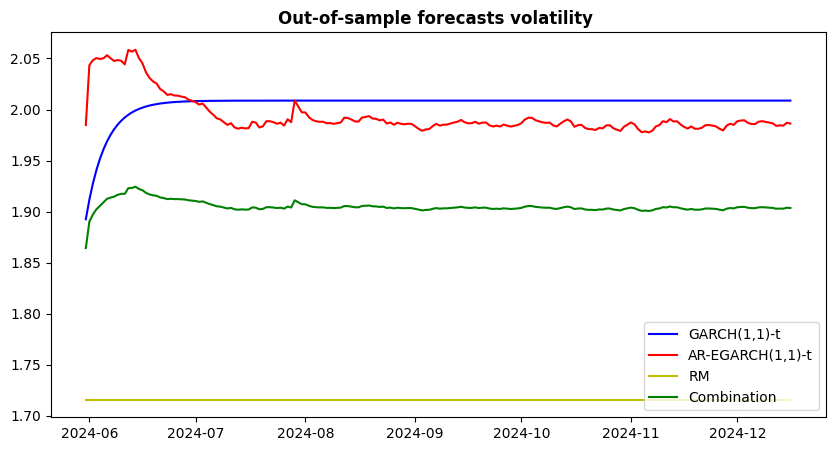

In [ ]:

import matplotlib.pyplot as plt
fig, axs = plt.subplots( 1, 1, figsize = (10,5) )
axs.plot( future_dates, sigGof, c = 'b', label = 'GARCH(1,1)-t' )
axs.plot( future_dates, sigEGof, c = 'r', label = 'AR-EGARCH(1,1)-t')
axs.plot( future_dates, sigRMof, c = 'y', label = 'RM')
axs.plot( future_dates, combos, c = 'g', label = 'Combination' )
axs.set_title( 'Out-of-sample forecasts volatility ', weight = 'bold' )
axs.legend(loc = 'lower right')
plt.show()


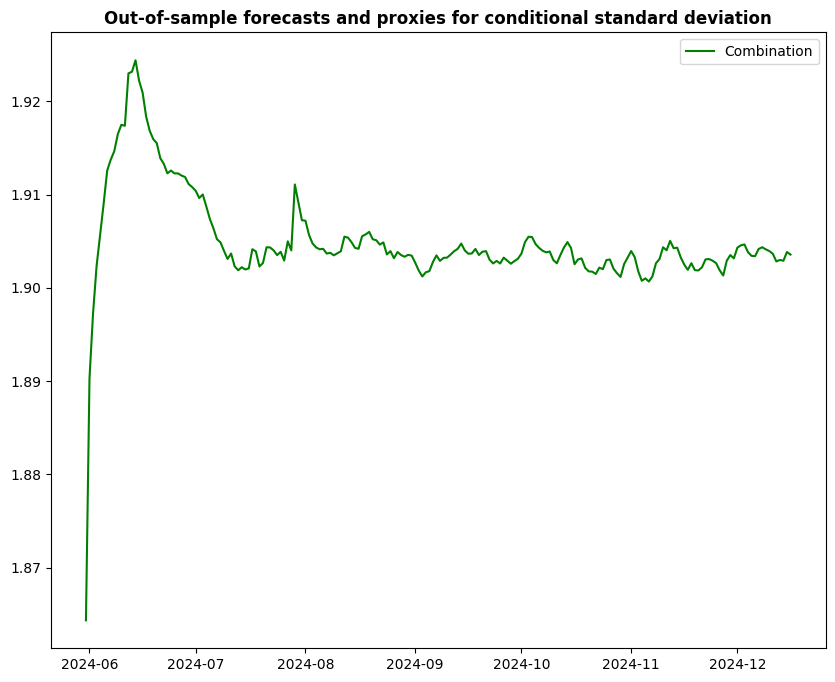

In [ ]:
# prompt: plot all the above

import matplotlib.pyplot as plt
fig, axs = plt.subplots( 1, 1, figsize = (10,8) )
axs.plot( future_dates, combos, c = 'g', label = 'Combination' )
axs.set_title( 'Out-of-sample forecasts and proxies for conditional standard deviation', weight = 'bold' )
axs.legend()
plt.show()

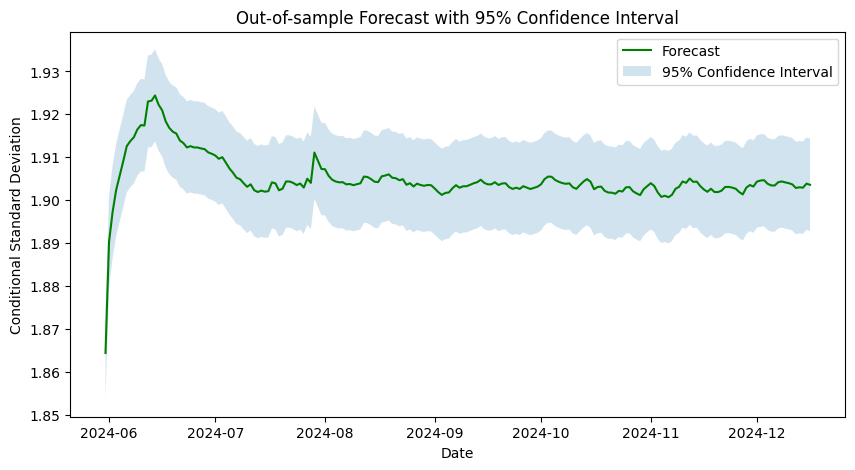

In [ ]:
# prompt: generate 95% CI for the forecast above and plot it

import numpy as np
import matplotlib.pyplot as plt

# Generate the 95% confidence interval for the forecast
ci_low = combos - 1.96 * np.std(combos)
ci_high = combos + 1.96 * np.std(combos)

# Plot the forecast and confidence interval
plt.plot(future_dates, combos, color = 'g', label='Forecast')
plt.fill_between(future_dates, ci_low, ci_high, alpha=0.2, label='95% Confidence Interval')
plt.title('Out-of-sample Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
plt.legend()
plt.show()
